# Friction models learning for Panda robot

In [1]:
import numpy as np
from numpy import random as rnd
from numpy.linalg import pinv
from numpy import linalg as lg
from scipy import linalg as slg
from importlib import reload
import seaborn as snb
import matplotlib.pyplot as plt
import Utils.Functions 
from Utils.Functions import *
import pbdlib as pbd
from scipy.linalg import hankel
import joblib
import pybullet
from pbdlib import LQR
from pbdlib.utils import get_canonical
import pandapybullet as ppb
import torch
import time
import GPy, GPyOpt
%load_ext autoreload
%autoreload 2
plt.style.use("default")
plt.rcParams['font.size'] = 13
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['lines.linewidth'] = 2.5
np.set_printoptions(precision=5, suppress=False)

## Gather training data 
### Define random sine reference

Run a LQR using desired joint position and velocity to retrieve joint acceleration

In [2]:
dt = 1e-3
world_sim = ppb.WorldSim()
world_sim.setup_scene()
world_sim.load_table()
robot = world_sim.load_panda()

In [21]:
N=30000
T = N*dt
n_training = 2
n_testing = 0
n_tot = n_training + n_testing
joint_limits = robot.joint_limits.copy()
joint_limits[1,:] = [-deg2rad(35),deg2rad(35)]
# joint_limits[3,0] = -deg2rad(60)

# Trajectories specifications
specs = {'phi': {'low': -np.pi, 'high': np.pi}, 
         'A': {'low': -np.pi, 'high': np.pi},
         'f': {'low': 1/15, 'high': .4},
         'nb_parts': 100, 'margin': .2, 'safety': .9}

RobotSim, RobotReal = Robot(7, 7, dt, N, robot), Robot(7, 7, dt, N, robot)
RobotSim.drawTrajectories(nb_traj=n_tot, q_limits=joint_limits, specs=specs)
RobotReal.ref, RobotReal.desired_ddq = RobotSim.ref, RobotSim.desired_ddq
RobotReal.nb_traj = RobotSim.nb_traj

## Gather training data using CTC + PD

### Tune PD controller

In [57]:
Kp = np.diag([70,90,70,70,80,170,150])
Ki = .2*np.eye(7)*70.
Kd = np.diag([10,10,10,10,8,30,30])

robot.reset_q(max_iter=100)
robot.joints_free=True

joints are free now


### Perturb robot dynamics

In [116]:
rnd.seed(3)
P_M, P_N = rnd.uniform(.92,1.08,size=(7)), rnd.uniform(.92,1.08,size=(7)) 
P_M, P_N = np.diag(P_M), np.diag(P_N)
F_v = .3*np.diag([3.,15.,2.,4.,.15,.2,.02]) # Viscous friction coefficient

In [7]:
def configuration_ctc(ddq, robot, P_M=np.eye(7), P_N=np.eye(7), **kwargs):
        
        if 'correction' in kwargs:
            correction = kwargs['correction']
        else: 
            correction = np.zeros([7])
        
        return np.dot(np.multiply(
            robot.M,P_M), ddq) + robot.b + (
            1-int(robot._gravity_compensation))*robot.g + P_N @ robot.damping@robot.dq + correction

### Simulate using CTC + PD

In [117]:
nb_modifs = 7
log_control = np.empty(shape=[n_tot,7,N-1])
log_control_model = np.empty(shape=[n_tot,7,N-1])
log_q = np.empty(shape=[n_tot,7,N])
log_dq = np.empty(shape=[n_tot,7,N])
log_ddq = np.empty(shape=[n_tot,7,N])

for n in range(n_tot):
    log_error = []
    sum_error = np.zeros(7)
    log_q[n,:,0] = robot.q
    log_dq[n,:,0] = robot.dq
    log_ddq[n,:,0] = robot.ddq
    
    robot.default_q = RobotReal.ref[n,:7,0]
    robot.reset_q(max_iter=100)
    robot.joints_free=True
    for i in range(0, N-1):
        error_q = RobotReal.ref[n,:7,i] - robot.q
        error_dq = RobotReal.ref[n,7:,i] - robot.dq

    #   Computed Torque Control
        control_input = configuration_ctc(Kp @ error_q + Ki @ sum_error + Kd @ error_dq + RobotReal.desired_ddq[n,:,i],
                                          robot)
#         control_input = configuration_ctc(Kp @ error_q + Ki @ sum_error + Kd @ error_dq + RobotReal.desired_ddq[n,:,i],
#                                           robot,
#                                           P_N=F_v
#                                          )
        # Add viscous friction
#         log_control_model[n,:,i] = control_input
        add_friction = F_v@robot.dq
        control_input -= add_friction
    
        for j in range(7):
            if control_input[j] < robot.joint_torque_limits[j,0]:
                control_input[j] = robot.joint_torque_limits[j,0].copy()
            if control_input[j] > robot.joint_torque_limits[j,1]:
                control_input[j] = robot.joint_torque_limits[j,1].copy()

        robot.set_torque(control_input[:7]) # Simulation
#         robot.set_torque(control_input[:7] - add_friction) # Real robot, with friction
#         robot.set_torque(save_controls[n,:,i] - add_friction) # Real robot, with friction

        log_error.append(np.copy(error_q))
        log_q[n,:,i] = robot.q.copy()
        log_dq[n,:,i] = robot.dq.copy()
        log_ddq[n,:,i] = robot.ddq.copy()
        log_control[n,:,i] = np.copy(control_input)
    #     time.sleep(dt)
        sum_error += error_q*dt
        
log_q[:,:,N-1] = log_q[:,:,N-2]
log_dq[:,:,N-1] = log_dq[:,:,N-2]

joints are free now
joints are free now


## Store data in state-space form

### Data for bad model (simulated)

In [92]:
RobotSim.toStateSpace(log_q[:nb_modifs], log_dq[:nb_modifs], log_control[:nb_modifs])

### Data for true dynamics (observed)

In [118]:
RobotReal.toStateSpace(log_q[:nb_modifs], log_dq[:nb_modifs], log_control[:nb_modifs])

### Difference dynamics
Here, the difference between the data simulated with the bad model with the suitable controller and the data gathered using the same controller but on the true system dynamics (which have synthetically been altered) is computed. <br><br>
$$ \delta X = X_0 - X_{model}$$ <br><br>
After that, the same algorithm leveraging HAVOK will be employed to retrieve a dynamical expression of the dynamical discrepancy.

In [119]:
delta_U = RobotReal.U - RobotSim.U
delta_X = RobotReal.X[:,:,:] - RobotSim.X[:,:,:]

### Plot for bad model (but rightly calibrated controller)

tensor(3.7004)


(Text(0.5, 0, 'Time [s]'), Text(0.5, 0, 'Time [s]'))

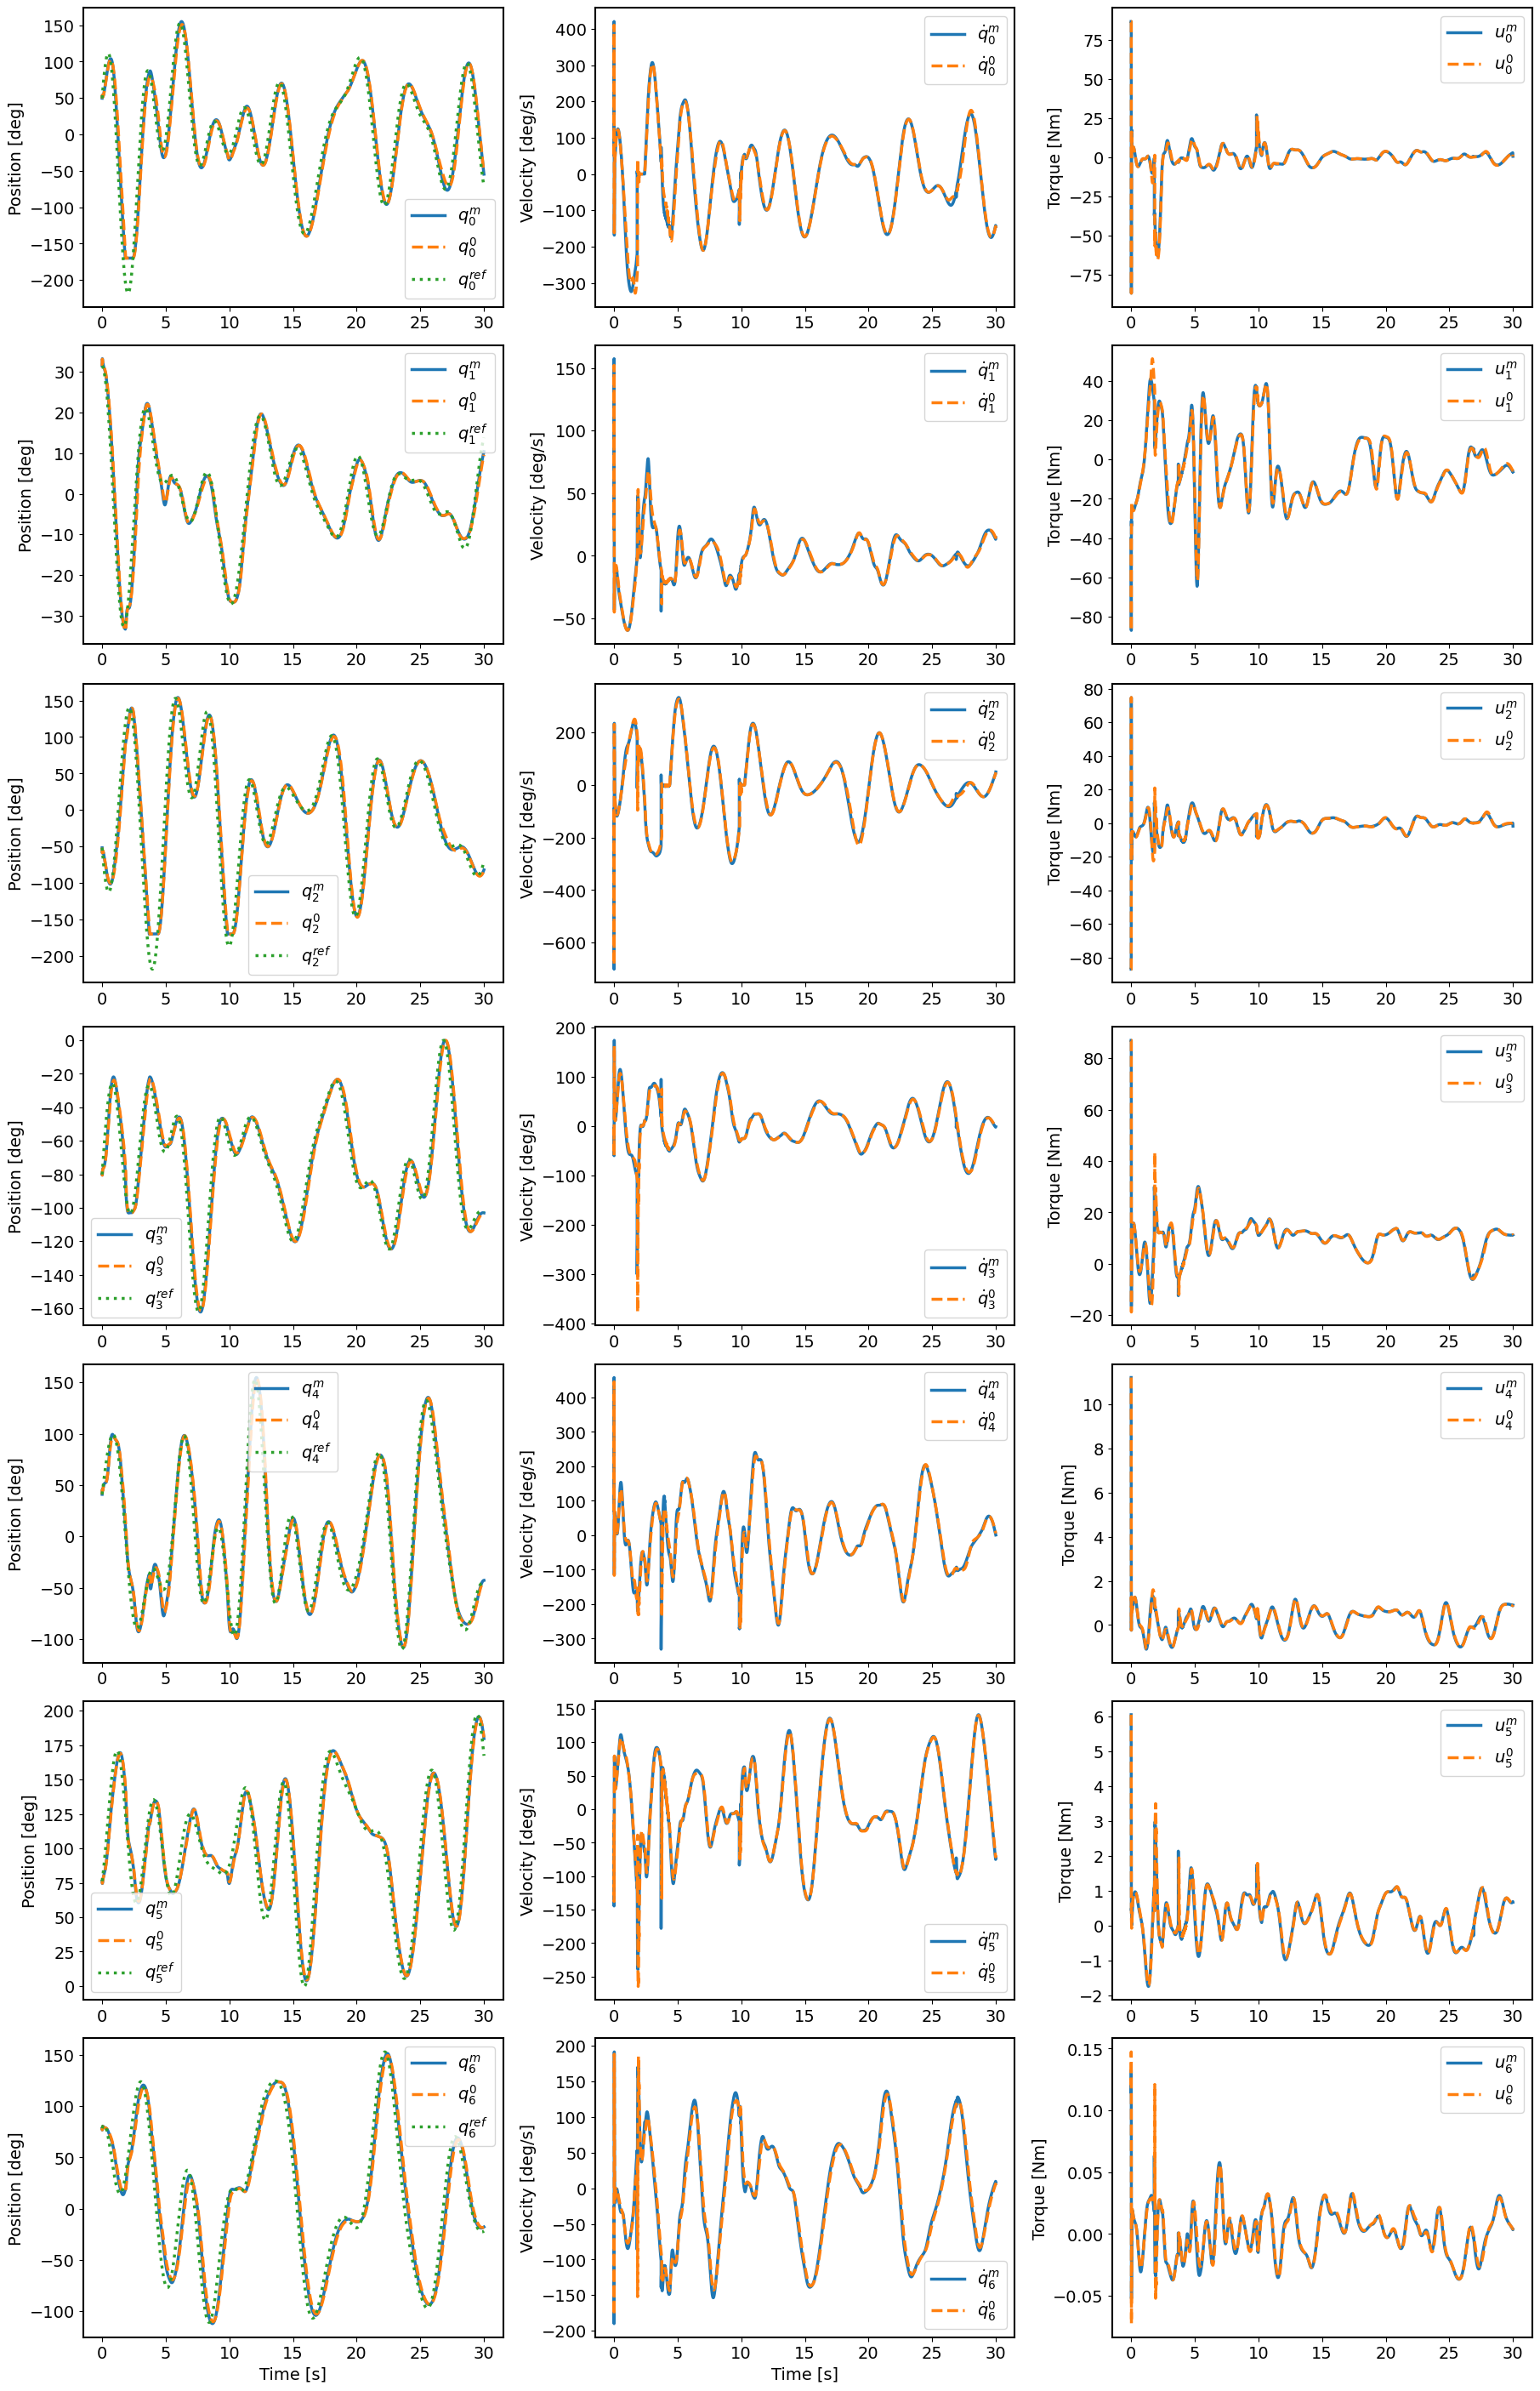

In [120]:
traj = 1
model = HAVOK()
RMSE = model.RMSE(X_true=RobotReal.X[traj,:nb_modifs,:],
                  X_pred=RobotSim.X[traj,:nb_modifs,:])
print(RMSE)
plt.rcParams['font.size'] = 14
fig, ax = plt.subplots(nb_modifs, 3, constrained_layout = True, figsize=(18,np.int(nb_modifs)*4))

for i in range(nb_modifs):
    
    ax[i,0].plot(RobotSim.T, rad2deg(RobotSim.X[traj,i,:]), label=r'$q^m_{%d}$'%i)
    ax[i,0].plot(RobotReal.T, rad2deg(RobotReal.X[traj,i,:]), label=r'$q^0_%d$'%i, linestyle='dashed')
    ax[i,0].plot(RobotSim.T, rad2deg(RobotSim.ref[traj,i,:]), label=r'$q^{ref}_%d$'%i, linestyle='dotted')
    ax[i,1].plot(RobotSim.T, rad2deg(RobotSim.X[traj,i+7,:]), label=r'$\dot{q}^m_{%d}$'%i)
    ax[i,1].plot(RobotReal.T, rad2deg(RobotReal.X[traj,i+7,:]), label=r'$\dot{q}^0_{%d}$'%i, linestyle='dashed')
    ax[i,2].plot(RobotSim.T[:-1], RobotSim.U[traj,i,:], label=r'$u^m_{%d}$'%i)
    ax[i,2].plot(RobotSim.T[:-1], RobotReal.U[traj,i,:], label=r'$u^0_{%d}$'%i, linestyle='dashed')
    ax[i,0].set_ylabel('Position [deg]'), ax[i,1].set_ylabel('Velocity [deg/s]'), ax[i,2].set_ylabel('Torque [Nm]')
    ax[i,0].legend(), ax[i,1].legend(), ax[i,2].legend()
    
ax[nb_modifs-1,0].set_xlabel('Time [s]'), ax[nb_modifs-1,1].set_xlabel('Time [s]')

### Plot residual dynamics

(Text(0.5, 0, 'Time [s]'), Text(0.5, 0, 'Time [s]'))

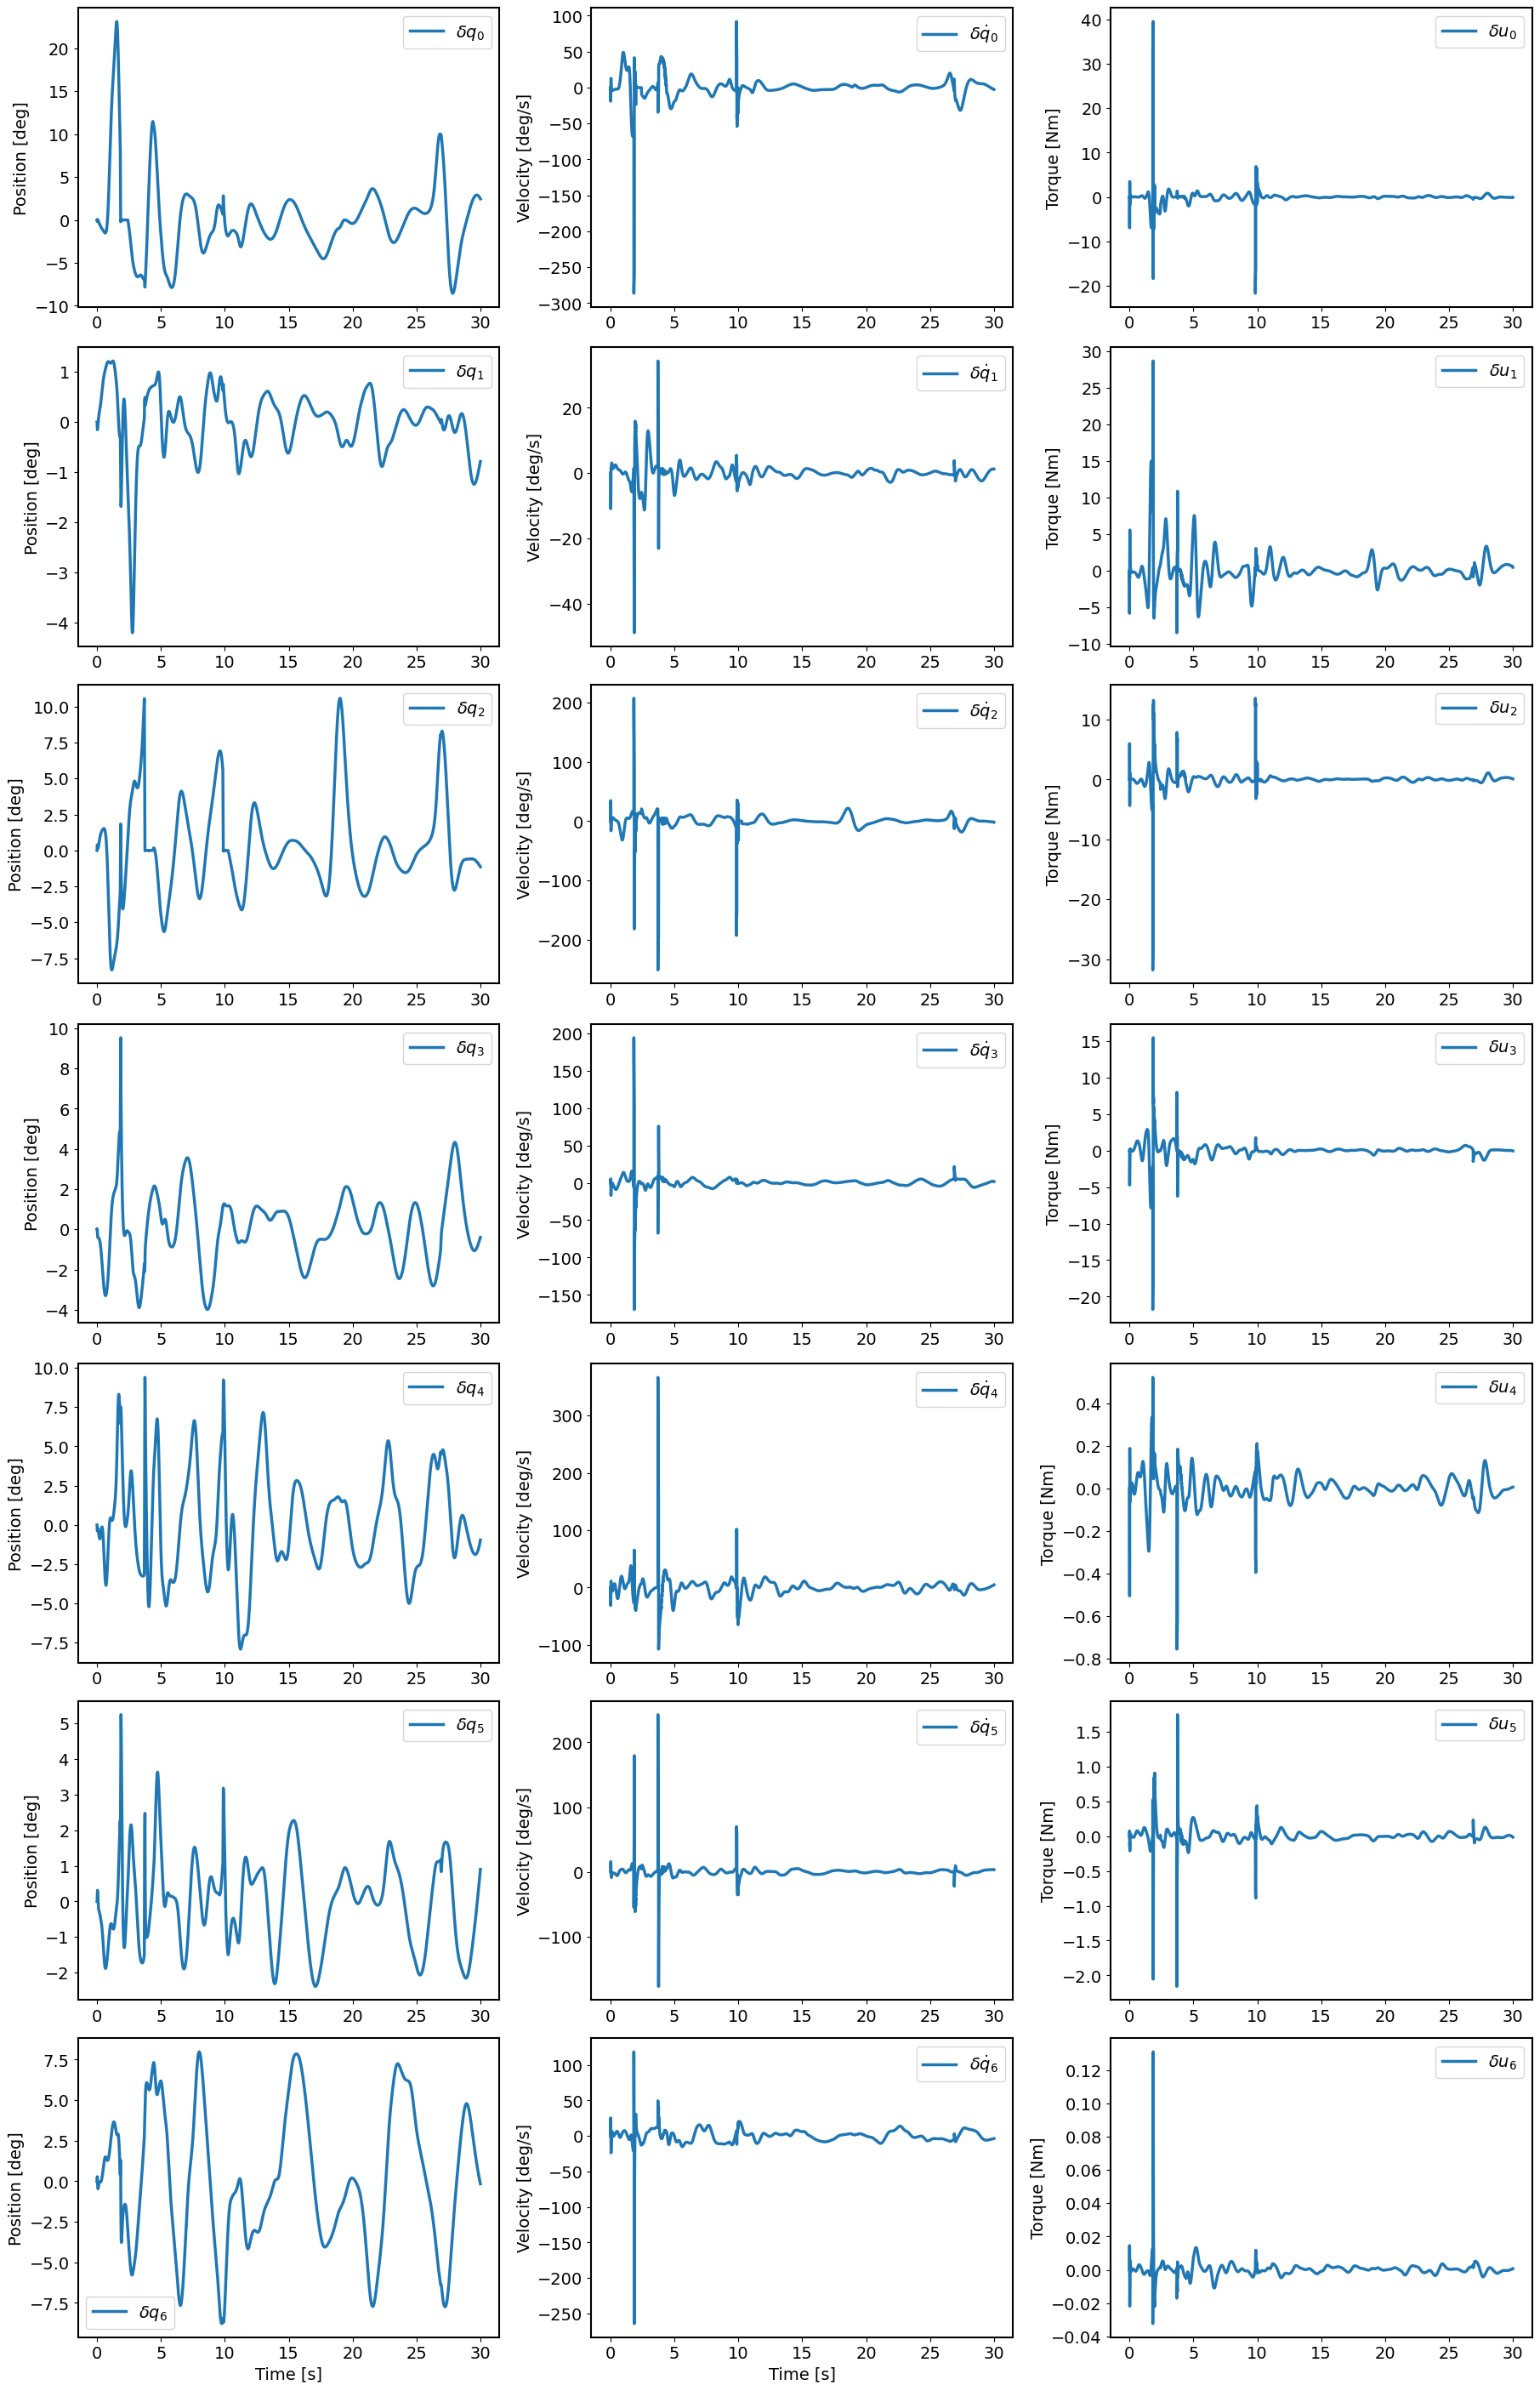

In [121]:
traj = 1
plt.rcParams['font.size'] = 14
fig, ax = plt.subplots(nb_modifs, 3, constrained_layout = True, figsize=(18,np.int(nb_modifs)*4))

for i in range(nb_modifs):
    
    ax[i,0].plot(RobotSim.T, rad2deg(delta_X[traj,i,:]), label=r'$\delta q_{%d}$'%i)
    ax[i,1].plot(RobotSim.T, rad2deg(delta_X[traj,i+7,:]), label=r'$\delta \dot{q}_{%d}$'%i)
    ax[i,2].plot(RobotSim.T[:-1], delta_U[traj,i,:], label=r'$\delta u_{%d}$'%i)
    ax[i,0].set_ylabel('Position [deg]'), ax[i,1].set_ylabel('Velocity [deg/s]'), ax[i,2].set_ylabel('Torque [Nm]')
    ax[i,0].legend(), ax[i,1].legend(), ax[i,2].legend()
    
ax[nb_modifs-1,0].set_xlabel('Time [s]'), ax[nb_modifs-1,1].set_xlabel('Time [s]')

In [20]:
nb_train, nb_test = 22500, 7500

## Model training 

### Using *GPyOpt*

In [122]:
nb_train, nb_test = 22500, 7500

traj_ratio = .05
n_low, n_high = 50, 200
d_low, d_high = 1, np.int((1-traj_ratio)/n_high*nb_train)
ref_zeros = np.zeros([14,nb_train-1])

domain = [
    {'name': 'dimension', 'type': 'discrete', 'domain': np.arange(14,50,1)},
    {'name': 'nb_traj', 'type': 'discrete', 'domain': np.arange(n_low,n_high,1)},
    {'name': 'nb_delays', 'type': 'discrete', 'domain': np.arange(d_low,d_high,1)}
]

print('delay max : ',np.int((1-traj_ratio)/n_high*nb_train))
print('points min : ',nb_train- d_high*n_high)

loss_prediction_train = np.empty(shape=[n_training])
loss_prediction_test = np.empty(shape=[n_training])
loss_corr = np.empty(shape=[n_training])
loss_LQR = np.empty(shape=[n_training])

N = RobotReal.X.shape[2]

def loss(space):
    # Model parameters
    n_params = space.shape[0] # If train by batch
    s = np.int(space[0,0])
    n = np.int(space[0,1])
    d = np.int(space[0,2])
#     nx = np.int(space[0,0])
#     nu = np.int(space[0,1])
#     d = np.int(space[0,2])
    
    timing = np.empty([2,n_training])
    
    for fold in range(n_training):
        timing[0,fold] = time.time() # HAVOK computation time
        
        # TRAINING #####################################################
        model = HAVOK(delta_X[fold,:,:nb_train], # state-wise difference
                      torch.cat((RobotSim.X[fold,:,:nb_train-1], # Exogenous inputs vector
                                 RobotSim.U[fold,:,:nb_train-1],
                                 delta_U[fold,:,:nb_train-1]),axis=0), 
                      mode='ELQR form',
                      nb_U=nb_modifs*4, # All inputs
                      nb_U_ex=nb_modifs*3 # Exogenous inputs
                     )
#         model = HAVOK(pandaRobot.X[fold,:,:nb_train], # state-wise difference
#                       pandaRobot.U[fold,:,:nb_train-1],
#                       mode='prediction'
#                      )
        model.HANKEL(n, d)
        model.SVD(s)
        model.LS(s,rcond=0)
        
        timing[0,fold] = time.time() - timing[0,fold]  
        timing[1,fold] = time.time() # Simulation time computation
        # TESTING ######################################################
        model.Simulate(X0=delta_X[fold,:,0],
                       horizon=nb_train,
                       U=torch.cat((RobotSim.X[fold,:,:nb_train],
                                    RobotSim.U[fold,:,:nb_train],
                                    delta_U[fold,:,:nb_train]),axis=0).to(torch.float)
                      )
        
        loss_prediction_train[fold] = model.RMSE(X_pred=model.X_prediction,
                                                 X_true=delta_X[fold,:,:nb_train])
        model.Simulate(X0=delta_X[fold,:,nb_train],
                       horizon=nb_test,
                       U=torch.cat((RobotSim.X[fold,:,nb_train:-1],
                                    RobotSim.U[fold,:,nb_train:],
                                    delta_U[fold,:,nb_train:]),axis=0).to(torch.float)
                      )
        loss_prediction_test[fold] = model.RMSE(X_pred=model.X_prediction,
                                                X_true=delta_X[fold,:,nb_train:])
        
        timing[1,fold] = time.time() - timing[1,fold]  
        
    loss_pred_train_sum = np.mean(loss_prediction_train)
    loss_pred_test_sum = np.mean(loss_prediction_test)
    loss = loss_pred_train_sum + loss_pred_test_sum
    avg_time = [timing[0,:].sum()/n_training,timing[1,:].sum()/n_training]
    
    if np.isnan(loss) or np.isinf(loss):
        loss = 1e10
        
#     print('Total loss : '+str(loss)+' Loss sim. : '+str(loss_traj_sum)+
#           ', s :'+str(s)+', n :'+str(n)+', d : '+str(d))
    print('Total loss : '+str(loss)+' Loss train. : '+str(loss_pred_train_sum)+
          ' Loss test. : '+str(loss_pred_test_sum)+
          ', r :'+str(s)+', n :'+str(n)+', d : '+str(d))
    print('Avg computation time for HAVOK : '+str(avg_time[0])+' [s], for sim. : '+str(avg_time[1])+' [s]')
    
    return loss

max_iter = 1000
batch_size = 6
num_cores = 6

opt = GPyOpt.methods.BayesianOptimization(f = loss,            # function to optimize       
                                          domain = domain,         # box-constraints of the problem
                                          acquisition_type ='LCB',       # LCB acquisition
                                          acquisition_weight = 0.2)     # Exploration exploitation
 

opt.run_optimization(max_iter)

delay max :  106
points min :  1300
Total loss : 10000000000.0 Loss train. : inf Loss test. : 118562236.1880188, r :36, n :119, d : 25
Avg computation time for HAVOK : 1.5592811107635498 [s], for sim. : 7.438017010688782 [s]
Total loss : 47939602.66620636 Loss train. : 47937765.35813141 Loss test. : 1837.3080749511719, r :16, n :154, d : 63
Avg computation time for HAVOK : 1.3748258352279663 [s], for sim. : 5.8084704875946045 [s]
Total loss : 14681895664.203884 Loss train. : 14681876521.537296 Loss test. : 19142.66658782959, r :16, n :160, d : 8
Avg computation time for HAVOK : 2.1886770725250244 [s], for sim. : 5.247378468513489 [s]
Total loss : 197420206.56485748 Loss train. : 197416459.11009216 Loss test. : 3747.454765319824, r :15, n :147, d : 44
Avg computation time for HAVOK : 1.3459031581878662 [s], for sim. : 4.7213757038116455 [s]
Total loss : 10000000000.0 Loss train. : nan Loss test. : 2.0763845446336664e+16, r :40, n :156, d : 34
Avg computation time for HAVOK : 1.817641615

## LQR control of the Panda robot
### Model prediction capabilities in training

In [1]:
# Train linear model
traj = 1

n = 330
r = 16
d = 24

model = HAVOK(delta_X[traj,:,:nb_train], # state-wise difference
              torch.cat((RobotSim.X[traj,:,:nb_train-1],
                         RobotSim.U[traj,:,:nb_train-1],
                         delta_U[traj,:,:nb_train-1]),axis=0), # model predicted states
              mode='ELQR form',
              nb_U=28,
              nb_U_ex=21
             )
# model = HAVOK(pandaRobot.X[traj,:,:nb_train], # state-wise difference
#               pandaRobot.U[traj,:,nb_train-1], # model predicted states
#               mode='prediction'
#              )
traj = 1
model.HANKEL(n, d)
model.SVD(r)
model.LS(r,rcond=0)
model.Simulate(delta_X[traj,:,0],
               horizon=nb_train + nb_test,
               U=torch.cat((RobotSim.X[traj,:,:-1],
                          RobotSim.U[traj,:,:],
                          delta_U[traj,:,:]),axis=0),
               )
# model.Simulate(pandaRobot.X[traj,:,0],
#                horizon=nb_train,
#                U=pandaRobot.U[traj,:,:nb_train],
#                )
# X_pred = pandaRobot.X[traj] + model.X_prediction
loss_traj = model.RMSE(X_pred=model.X_prediction,
                       X_true=delta_X[traj,:,:])
# loss_traj = model.RMSE(X_pred=model.X_prediction[:,:],
#                        X_true=RobotSim.X[traj,:,:])
# loss_model = model.RMSE(X_pred=pandaRobot.X[traj],
#                                     X_true=pandaRobot2.X[traj])
print(loss_traj)
# print(loss_model)

# plt.rcParams['font.size'] = 20
# fig, ax = plt.subplots(1, 2, constrained_layout = True, figsize=(18,8))

# figA = snb.heatmap(model.A,cmap='Reds',ax=ax[0])
# figB = snb.heatmap(model.B,cmap='Reds',ax=ax[1])

plt.rcParams['font.size'] = 14
fig, ax = plt.subplots(7, 1, constrained_layout = True, figsize=(14,25))

for i in range(7):
    
    ax[i].plot(RobotSim.T[:], rad2deg(model.X_prediction[i,:]), label=r'$\delta \hat{q}$')
    ax[i].plot(RobotSim.T[:], rad2deg(delta_X[traj,i,:]), label=r'$\delta q$', linestyle='dashed')
    ax[i].set_ylabel('Pos. [deg]')
    ax[i].legend()
    
ax[6].set_xlabel('Time [s]')

NameError: name 'HAVOK' is not defined

### Leveraging ELQR for residual dynamics cancellation

In [1]:
# Train linear model #######################################
traj = 1
horizon = 1000
# Correct trajectories with ELQR ############################
u_d = torch.cat((RobotSim.X[traj,:,:horizon],
                 RobotSim.U[traj,:,:horizon]),axis=0)
model.toNumpy()
model.ConstructLQR(x_std=1e6*np.ones([7]),
                   u_std=-1.,
                   dt=RobotSim.dt,
                   horizon=horizon,
                   mode='ELQR',
                   u_d=u_d,
                   Bd=model.Bd
                  )
model.LQR_simulate(delta_X[traj,:,0].numpy(),
                   mode='ELQR', 
                   u_d=u_d,
                   Bd=model.Bd
                  )

traj = 0
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(7, 2, constrained_layout = True, figsize=(18,11))

for i in range(7):
    
    ax[i,0].plot(RobotReal.T, rad2deg(model.LQR_X[i,:]), label=r'$\Delta x_{LQR}$')
    ax[i,0].plot(RobotReal.T, rad2deg(delta_X[traj,i,:]), label=r'$\Delta x$')
    ax[i,1].plot(RobotReal.T, rad2deg(RobotReal.X[traj,i+7,:]), label=r'$u_{LQR}$')
    ax[i,0].set_ylabel('Position [deg]'), ax[i,1].set_ylabel('Torque [Nm]')
    ax[i,0].legend(), ax[i,1].legend()
    
ax[6,0].set_xlabel('Time [s]'), ax[6,1].set_xlabel('Time [s]')

NameError: name 'torch' is not defined

In [73]:
np.array(model.LQR.K).shape

(29998, 7, 22)

In [79]:
(np.concatenate((robot.q,robot.dq)) - RobotSim.X[traj,:,i].numpy()).shape

(14,)

### Corrected trajectories

In [102]:
log_control = np.empty(shape=[7,N-1])
log_control_model = np.empty(shape=[7,N-1])
log_q = np.empty(shape=[7,N])
log_dq = np.empty(shape=[7,N])
log_ddq = np.empty(shape=[7,N])

log_error = []
sum_error = np.zeros(7)
log_q[:,0] = robot.q
log_dq[:,0] = robot.dq
log_ddq[:,0] = robot.ddq

K = (np.array(model.LQR.K) @ model.pinvC)

robot.default_q = RobotReal.ref[traj,:7,0]
robot.reset_q(max_iter=100)
robot.joints_free=True
for i in range(0, N-2):
    error_q = RobotReal.ref[traj,:7,i] - robot.q
    error_dq = RobotReal.ref[traj,7:,i] - robot.dq

#   Computed Torque Control
    control_input = configuration_ctc(Kp @ error_q + Ki @ sum_error + Kd @ error_dq + 
                                      RobotReal.desired_ddq[traj,:,i],
#                                       K[i,:,:] @ (np.concatenate((log_q[:,i-1],
#                                                                   log_dq[:,i-1])) - 
#                                                     RobotSim.X[traj,:,i].numpy()),
                                      robot,
                                      correction= + K[i,:,:] @ (log_q[:,i-1] - 
                                                                RobotSim.X[traj,:,i].numpy()
                                                               )
                                     )
    # Add viscous friction
    add_friction = F_v@robot.dq
    control_input -= add_friction

    for j in range(7):
        if control_input[j] < robot.joint_torque_limits[j,0]:
            control_input[j] = robot.joint_torque_limits[j,0].copy()
        if control_input[j] > robot.joint_torque_limits[j,1]:
            control_input[j] = robot.joint_torque_limits[j,1].copy()

    robot.set_torque(control_input[:7]) # Simulation

    log_error.append(np.copy(error_q))
    log_q[:,i] = robot.q.copy()
    log_dq[:,i] = robot.dq.copy()
    log_ddq[:,i] = robot.ddq.copy()
    log_control[:,i] = np.copy(control_input)
#     time.sleep(dt)
    sum_error += error_q*dt
        
log_q[:,N-1] = log_q[:,N-2]
log_dq[:,N-1] = log_dq[:,N-2]

joints are free now


(Text(0.5, 0, 'Time [s]'), Text(0.5, 0, 'Time [s]'))

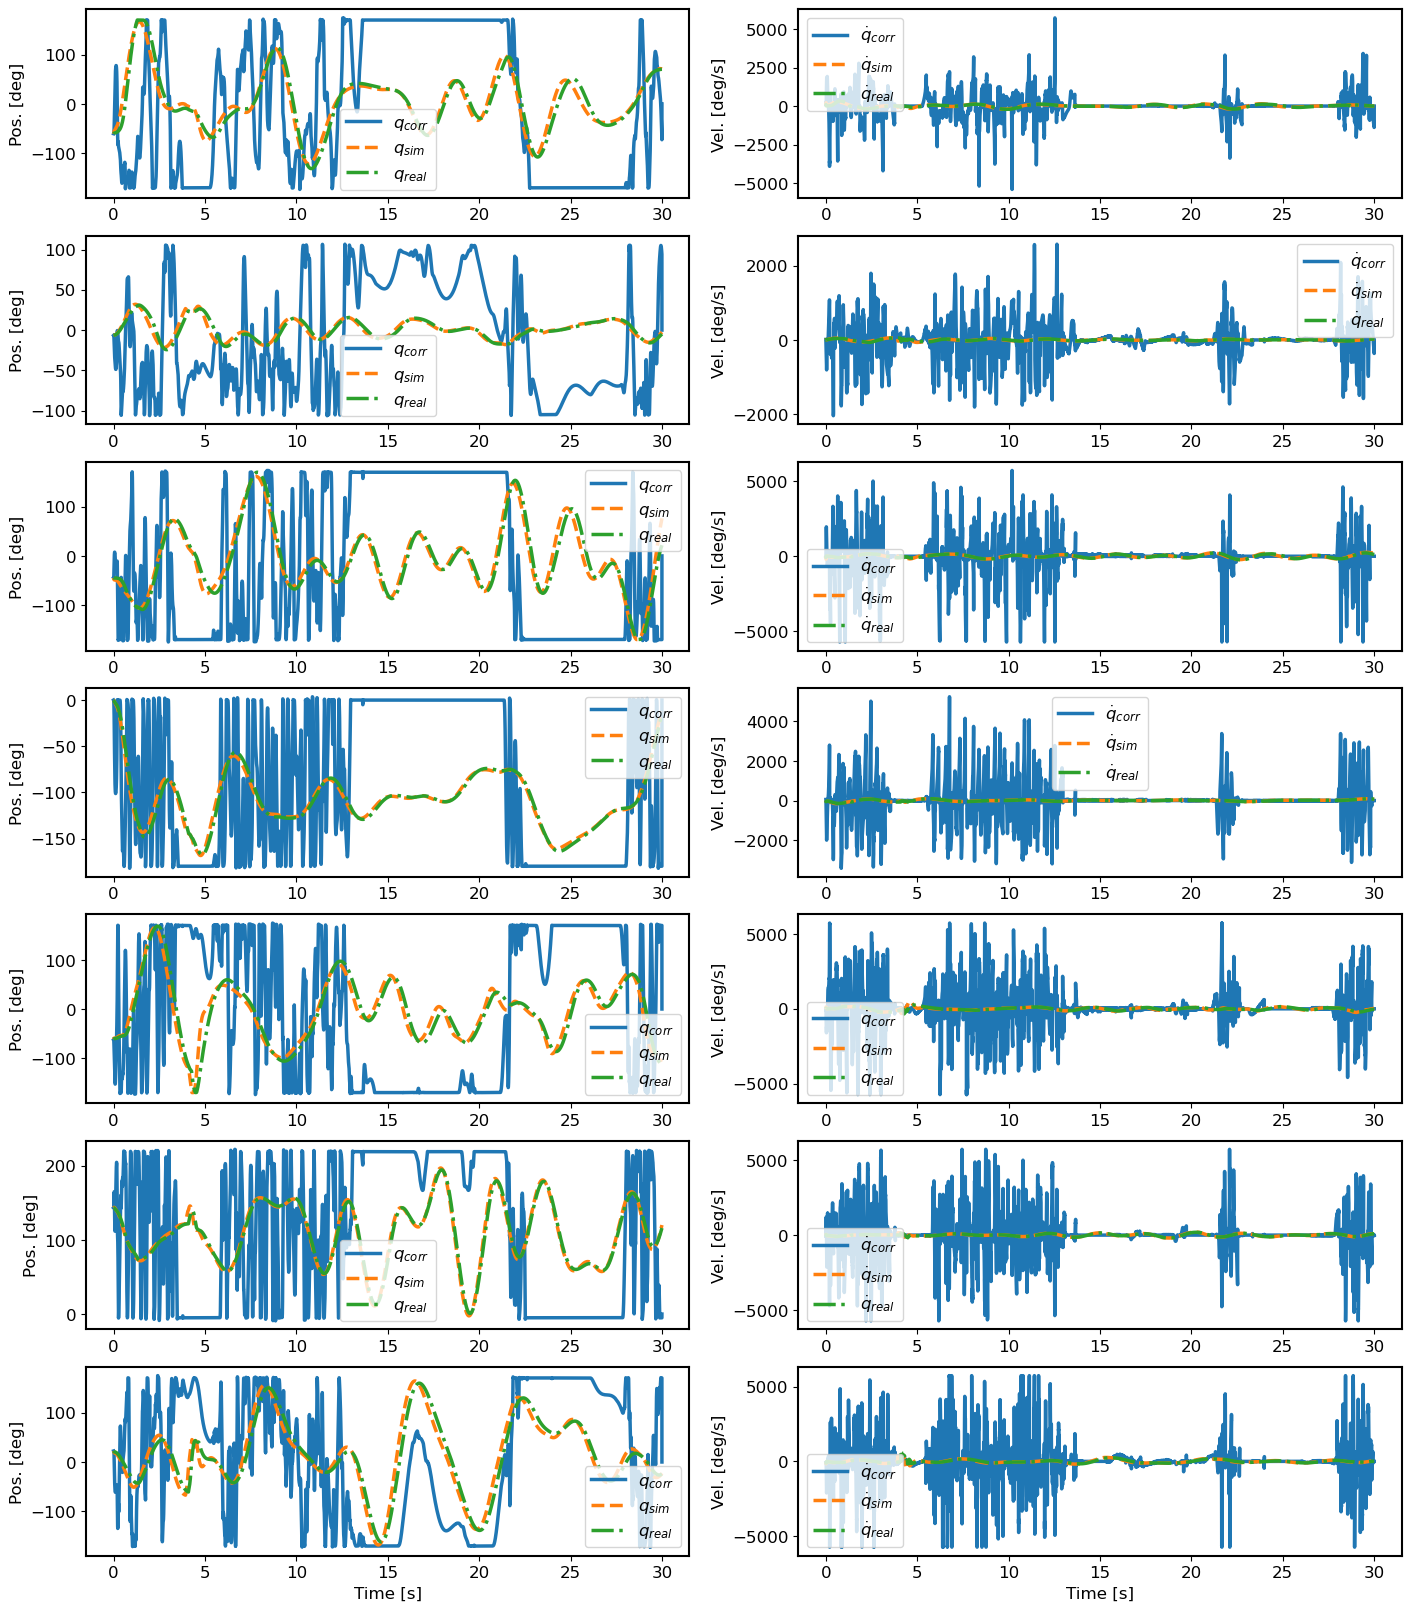

In [103]:
plt.rcParams['font.size'] = 12
fig, ax = plt.subplots(7, 2, constrained_layout = True, figsize=(14,16))

for i in range(7):
    
    ax[i,0].plot(RobotSim.T[:], rad2deg(log_q[i,:]), label=r'$q_{corr}$')
    ax[i,0].plot(RobotSim.T[:], rad2deg(RobotSim.X[traj,i,:]), label=r'$q_{sim}$', linestyle='dashed')
    ax[i,0].plot(RobotSim.T[:], rad2deg(RobotReal.X[traj,i,:]), label=r'$q_{real}$', linestyle='dashdot')
    ax[i,1].plot(RobotSim.T[:], rad2deg(log_dq[i,:]), label=r'$\dot{q}_{corr}$')
    ax[i,1].plot(RobotSim.T[:], rad2deg(RobotSim.X[traj,7+i,:]), label=r'$\dot{q}_{sim}$', linestyle='dashed')
    ax[i,1].plot(RobotSim.T[:], rad2deg(RobotReal.X[traj,7+i,:]), label=r'$\dot{q}_{real}$', linestyle='dashdot')
    ax[i,0].set_ylabel('Pos. [deg]'), ax[i,1].set_ylabel('Vel. [deg/s]')
    ax[i,0].legend(), ax[i,1].legend()
    
ax[6,0].set_xlabel('Time [s]'), ax[6,1].set_xlabel('Time [s]')